In [9]:
!pip install nltk

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import requests
import zipfile
import os
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xyzen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xyzen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
#1
def download_file(url, filename):
    """
    Download a file from a given URL and save it locally.
    
    Parameters:
    - url: The URL of the file to download.
    - filename: The local path where the file should be saved.
    """
    with requests.get(url, stream=True) as r:
        r.raise_for_status()  # This will raise an error for bad responses
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print(f"File downloaded successfully: {filename}")

def decompress_zip(zip_file_path, extract_to_dir):
    """
    Decompress a zip file and save the decompressed data.
    
    Parameters:
    - zip_file_path: The path of the zip file to decompress.
    - extract_to_dir: The directory to extract the files to.
    """
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
    print(f"Files extracted successfully to: {extract_to_dir}")

# Enter the URLs of the files you have found
file_urls = [
    "https://s3.amazonaws.com/weruns/forfun/Indiegogo/Indiegogo_2024-03-14T07_53_50_408Z.zip",
    "https://s3.amazonaws.com/weruns/forfun/Indiegogo/Indiegogo_2024-02-16T20_40_32_944Z.zip"
]
download_dir = "D:/course/CS688/3/downloaded_files"  # Specify your download directory
os.makedirs(download_dir, exist_ok=True)  # Create the directory if it does not exist

# Perform download and unzip operations for each ZIP file
all_titles = []  # Initialize an empty list to collect all titles
for i, url in enumerate(file_urls[:6]):
    zip_filename = os.path.join(download_dir, f"file_{i}.zip")
    extract_to_dir = os.path.join(download_dir, f"extracted_{i}")
    
    download_file(url, zip_filename)
    decompress_zip(zip_filename, extract_to_dir)

    # Assume each ZIP contains multiple CSV files, we process each
    for csv_filename in os.listdir(extract_to_dir):
        if csv_filename.endswith(".csv"):
            csv_path = os.path.join(extract_to_dir, csv_filename)
            df = pd.read_csv(csv_path)
            titles = df['title'].dropna().tolist()
            all_titles.extend(titles)

# Save all titles to a single CSV file
titles_df = pd.DataFrame(all_titles, columns=['Title'])
output_csv_path = "D:/course/CS688/3/all_titles.csv"
titles_df.to_csv(output_csv_path, index=False)

print(f"All titles have been saved to {output_csv_path}")


File downloaded successfully: D:/course/CS688/3/downloaded_files\file_0.zip
Files extracted successfully to: D:/course/CS688/3/downloaded_files\extracted_0
File downloaded successfully: D:/course/CS688/3/downloaded_files\file_1.zip
Files extracted successfully to: D:/course/CS688/3/downloaded_files\extracted_1
All titles have been saved to D:/course/CS688/3/all_titles.csv


In [49]:
#2
# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english') + stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]  # Remove stopwords and perform lemmatization
    return ' '.join(words)  # Return the processed text string

# Assume titles_df is a DataFrame containing all titles
# titles_df = pd.DataFrame(all_titles, columns=['Title'])

# Apply the preprocessing function to each title
titles_df['Processed_Title'] = titles_df['Title'].apply(preprocess)

# Use the Bag of Words model to create a term-document matrix
vectorizer = CountVectorizer(token_pattern=r'\b[a-zA-Z]+\b')
X = vectorizer.fit_transform(titles_df['Processed_Title'])

print("Term-Document Matrix Shape:", X.shape)
print("Feature Names:", vectorizer.get_feature_names_out())


Term-Document Matrix Shape: (145428, 25343)
Feature Names: ['aa' 'aaa' 'aadongle' ... 'zyn' 'zynge' 'zzhive']


In [50]:
import pandas as pd

# Assume you want to view the first 10 rows of the matrix
subset_X = X[:10]

# Convert the subset of the sparse matrix to a DataFrame
subset_X_df = pd.DataFrame(subset_X.toarray(), columns=vectorizer.get_feature_names_out())

# Specify the subset output file path
output_subset_csv = "D:/course/CS688/3/term_document_matrix_subset.csv"

# Save the subset to a CSV file
subset_X_df.to_csv(output_subset_csv, index=False)

print(f"Subset of Term-Document Matrix has been saved to {output_subset_csv}")


Subset of Term-Document Matrix has been saved to D:/course/CS688/3/term_document_matrix_subset.csv


In [51]:
import pandas as pd

# Assume vectorizer is your already fitted CountVectorizer instance
feature_names = vectorizer.get_feature_names_out()

# Convert feature names into a DataFrame
features_df = pd.DataFrame(feature_names, columns=['Feature Names'])

# Specify the output file path
output_feature_names_csv = "D:/course/CS688/3/feature_names.csv"

# Save to a CSV file
features_df.to_csv(output_feature_names_csv, index=False)

print(f"Feature names have been saved to {output_feature_names_csv}")


Feature names have been saved to D:/course/CS688/3/feature_names.csv


In [52]:
#3
# Initialize the TF-IDF transformer
tfidf_transformer = TfidfTransformer()

# Apply the TF-IDF transformation
X_tfidf = tfidf_transformer.fit_transform(X)

print("Shape of TF-IDF Matrix:", X_tfidf.shape)


Shape of TF-IDF Matrix: (145428, 25343)


In [53]:
#4
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

# Dimensionality reduction using LSA (Latent Semantic Analysis)
svd_model = TruncatedSVD(n_components=100)  # n_components is the estimated number of topics
X_lsa = svd_model.fit_transform(X_tfidf)

# Clustering using KMeans
num_clusters = 5  # Assume the desired number of clusters
km_model = KMeans(n_clusters=num_clusters)
km_model.fit(X_lsa)

# Retrieve cluster labels
lsa_clusters = km_model.labels_


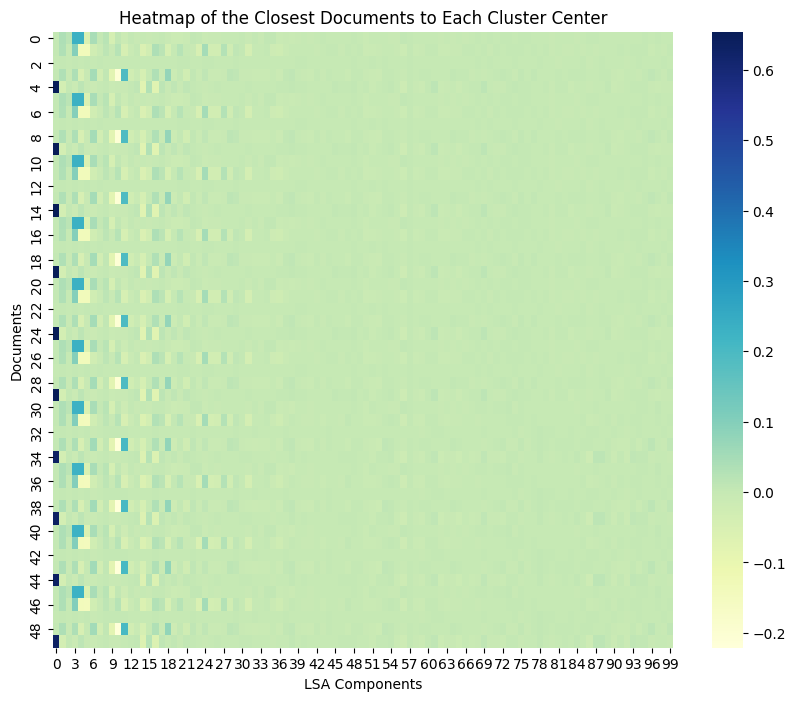

In [66]:
from sklearn.metrics.pairwise import euclidean_distances

# Assume the KMeans model km_model is already fitted, and X_lsa is the matrix after LSA dimensionality reduction
cluster_centers = km_model.cluster_centers_

# Calculate the distance of each document to its cluster center
distances = euclidean_distances(X_lsa, cluster_centers)

# Select the closest N documents in each cluster
N = 10  # The number of documents you want to select in each cluster
closest_docs_indices = np.argsort(distances, axis=0)[:N, :]

# Generate heatmap data representing these documents
closest_docs_lsa = X_lsa[closest_docs_indices.ravel()]

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(closest_docs_lsa, cmap="YlGnBu")
plt.title('Heatmap of the Closest Documents to Each Cluster Center')
plt.xlabel('LSA Components')
plt.ylabel('Documents')
plt.show()
# Visually inspect the heatmap for documents with deeper colors and note them in the selected_documents below


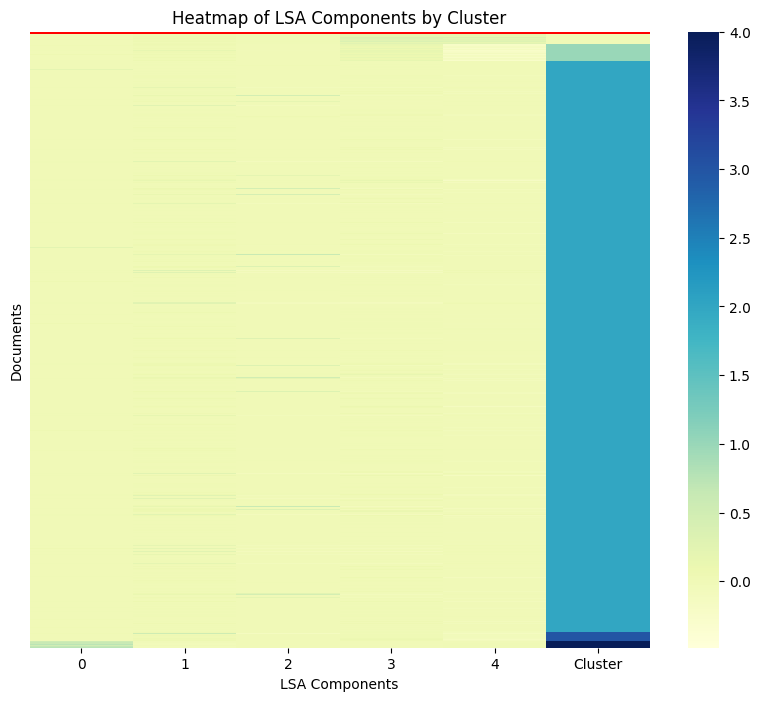

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df_lsa_sorted is a DataFrame of the LSA dataset sorted by cluster
# Extract rows for specific documents
# selected_documents = df_lsa_sorted.iloc[[0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49], :]
selected_documents = df_lsa_sorted.iloc[[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53], :]

# Create a heatmap and mark selected documents
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df_lsa_sorted, cmap="YlGnBu", yticklabels=False)
# Add marks at the selected documents
for doc in [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53]:
    heatmap.add_patch(plt.Rectangle((0, doc), df_lsa_sorted.shape[1], 1, fill=False, edgecolor='red', lw=2))
plt.title('Heatmap of LSA Components by Cluster')
plt.xlabel('LSA Components')
plt.ylabel('Documents')
plt.show()



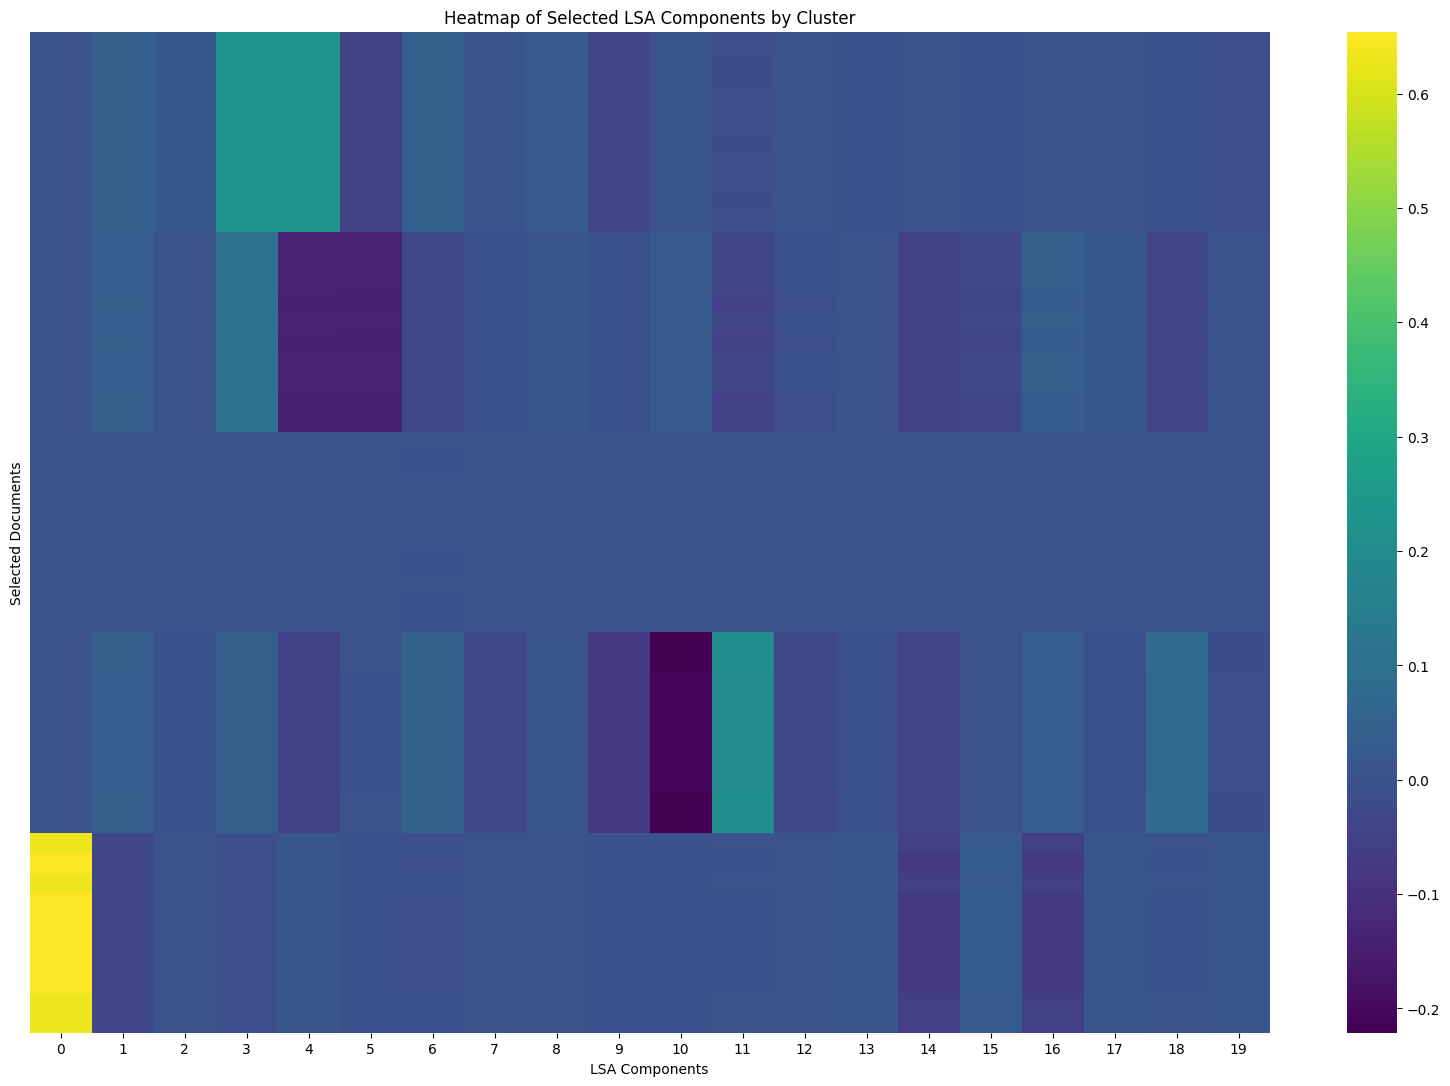

In [97]:
# Assume X_lsa is the data after dimension reduction, and lsa_clusters are the cluster labels
df_lsa = pd.DataFrame(X_lsa[:, :20])  # Only considering the first 20 components
df_lsa['Cluster'] = lsa_clusters

# Only select documents closest to each cluster center to construct the heatmap
selected_docs_indices = closest_docs_indices.ravel()
df_selected = df_lsa.iloc[selected_docs_indices]

# Sort by cluster for heatmap display grouped by cluster
df_selected_sorted = df_selected.sort_values('Cluster')

# Create the heatmap
plt.figure(figsize=(20, 13))
sns.heatmap(df_selected_sorted.drop('Cluster', axis=1), cmap="viridis", yticklabels=False)
plt.title('Heatmap of Selected LSA Components by Cluster')
plt.xlabel('LSA Components')
plt.ylabel('Selected Documents')
plt.show()


In [102]:
from sklearn.decomposition import LatentDirichletAllocation

# Perform topic modeling using LDA (Latent Dirichlet Allocation)
lda_model = LatentDirichletAllocation(n_components=10,  # n_components is the estimated number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs=-1)
X_lda = lda_model.fit_transform(X_tfidf)

# In the LDA model, the topic distribution of each document can directly serve as clustering results, no additional clustering step needed
# The most likely topic for each document
lda_clusters = X_lda.argmax(axis=1)
# Count the number of documents per topic
topic_counts = np.bincount(lda_clusters)
# Display the number of documents for each topic
for i, count in enumerate(topic_counts):
    print(f"Topic #{i} has {count} documents")


Topic #0 has 15371 documents
Topic #1 has 14392 documents
Topic #2 has 14680 documents
Topic #3 has 14395 documents
Topic #4 has 13032 documents
Topic #5 has 14207 documents
Topic #6 has 14242 documents
Topic #7 has 14855 documents
Topic #8 has 15677 documents
Topic #9 has 14577 documents


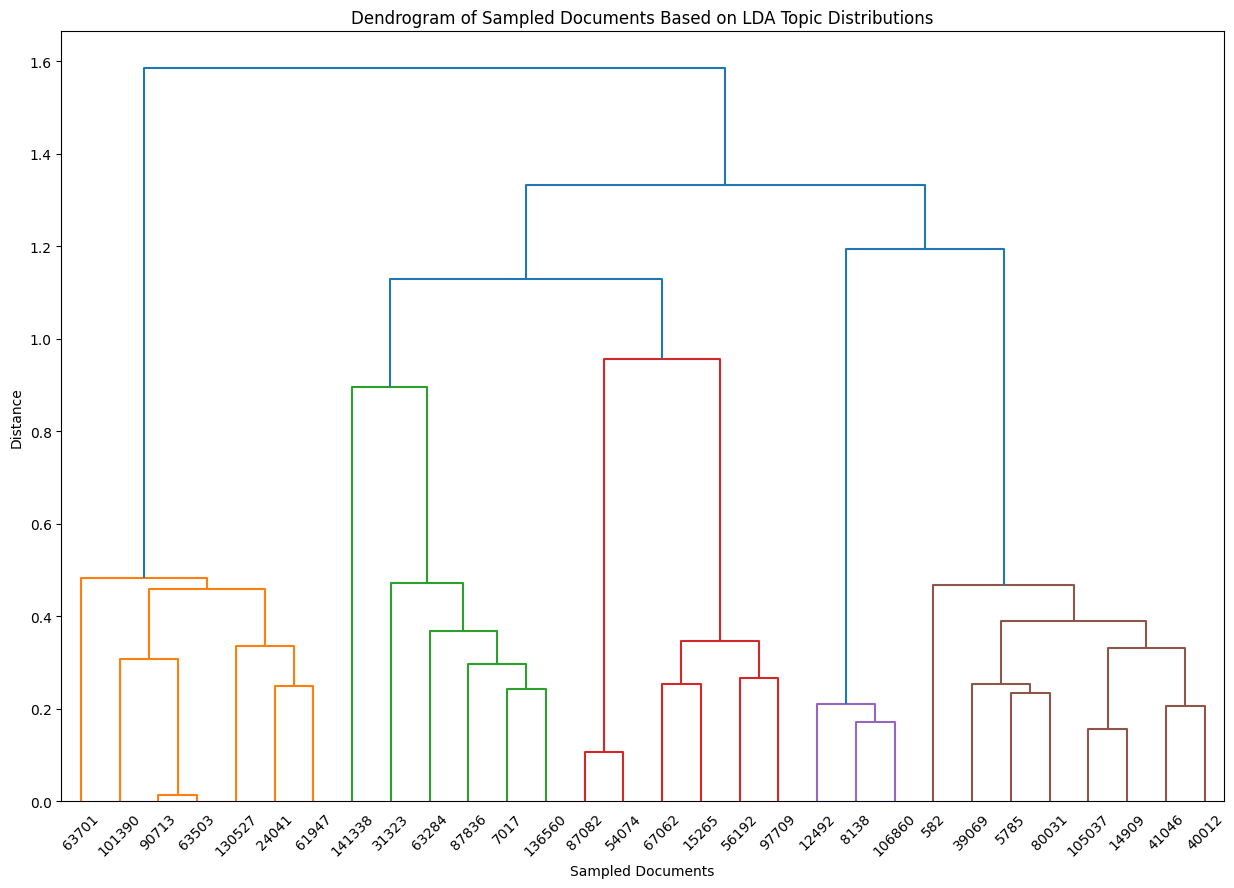

In [113]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# Assume X_tfidf is your TF-IDF matrix
# Choose the appropriate number of topics based on your resources
n_components = 10  
lda_model = LatentDirichletAllocation(n_components=n_components, 
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs=-1)  # Use all CPU cores
X_lda = lda_model.fit_transform(X_tfidf)

# Select a smaller sample size for clustering
sample_size = 30  # Adjust the sample size as needed
np.random.seed(0)
sample_indices = np.random.choice(range(X_lda.shape[0]), size=sample_size, replace=False)
sampled_X_lda = X_lda[sample_indices]

# Perform hierarchical clustering
# AgglomerativeClustering uses 'euclidean' affinity and 'ward' linkage by default, no need to specify
agglomerative_model = AgglomerativeClustering(n_clusters=n_components)
clusters = agglomerative_model.fit_predict(sampled_X_lda)

# For visualization, only plot the dendrogram for the sampled documents
linkage_matrix = linkage(sampled_X_lda, method='ward')
plt.figure(figsize=(15, 10))
sample_labels = [str(i) for i in sample_indices]
dendrogram(linkage_matrix, labels=sample_labels)  
plt.title('Dendrogram of Sampled Documents Based on LDA Topic Distributions')
plt.xlabel('Sampled Documents')
plt.ylabel('Distance')
plt.show()


